In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(-2), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
two = int(3)*train_x**int(2) + torch.randn(train_x.size()) * float(0.2)

# Combined poly + sin/cos
#one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
#one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)

train_y = torch.stack([one,two], int(-1))
#train_y = torch.stack([one, two], int(-1))


In [3]:
print(train_x)
print(train_y)
print(np.shape(train_y))

# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([-2.0000, -1.9184, -1.8367, -1.7551, -1.6735, -1.5918, -1.5102, -1.4286,
        -1.3469, -1.2653, -1.1837, -1.1020, -1.0204, -0.9388, -0.8571, -0.7755,
        -0.6939, -0.6122, -0.5306, -0.4490, -0.3673, -0.2857, -0.2041, -0.1224,
        -0.0408,  0.0408,  0.1224,  0.2041,  0.2857,  0.3673,  0.4490,  0.5306,
         0.6122,  0.6939,  0.7755,  0.8571,  0.9388,  1.0204,  1.1020,  1.1837,
         1.2653,  1.3469,  1.4286,  1.5102,  1.5918,  1.6735,  1.7551,  1.8367,
         1.9184,  2.0000])
tensor([[-7.8371e+00,  1.1940e+01],
        [-7.2361e+00,  1.1195e+01],
        [-6.2724e+00,  1.0543e+01],
        [-5.1642e+00,  9.0511e+00],
        [-4.4182e+00,  8.3335e+00],
        [-3.4487e+00,  7.6546e+00],
        [-3.6068e+00,  6.7872e+00],
        [-3.1169e+00,  5.7837e+00],
        [-2.7957e+00,  5.4096e+00],
        [-1.8974e+00,  4.5509e+00],
        [-1.4125e+00,  4.2917e+00],
        [-1.4308e+00,  3.5176e+00],
        [-1.2418e+00,  3.5221e+00],
        [-6.9079e-01,  2.

In [4]:

len(train_y.shape)

2

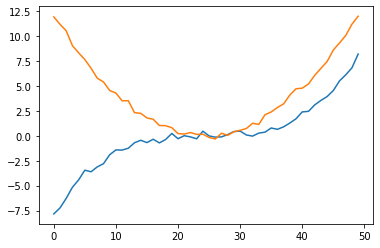

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1^2, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[            k1       dx2^2*k1]
[      dx1^2*k1 dx1^2*dx2^2*k1]

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1, 1))
        R = matrix(2, 2, (1, dx2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        #self.covar_module = MatrixKernel([[kernel0, kernel2], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]


In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[ 1.0000e+00,  0.0000e+00,  9.9667e-01,  ..., -1.8160e-03,
          3.3546e-04, -1.3419e-03],
        [ 0.0000e+00,  1.0000e+00,  8.1361e-02,  ..., -6.6522e-03,
          1.3419e-03, -5.0319e-03],
        [ 9.9667e-01,  8.1361e-02,  1.0000e+00,  ..., -2.4403e-03,
          4.6345e-04, -1.8160e-03],
        ...,
        [-1.8160e-03, -6.6522e-03, -2.4403e-03,  ...,  1.0000e+00,
          8.1361e-02,  9.9003e-01],
        [ 3.3546e-04,  1.3419e-03,  4.6345e-04,  ...,  8.1361e-02,
          1.0000e+00,  0.0000e+00],
        [-1.3419e-03, -5.0319e-03, -1.8160e-03,  ...,  9.9003e-01,
          0.0000e+00,  1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2969e+01,  0.0000e+00],
        [ 2.8123e+01,  0.0000e+00],
        [ 1.8031e+01,  0.0000e+00],
        [ 1.1853e+01,  0.0000e+00],
        [ 6.0685e+00,  0.0000e+00],
        [ 2.2329e+00,  0.0000e+00],
        [ 5.8205e-01,  0.0000e+00],
        [ 1.1878e-01,  0.0000e+00],
        [ 2.0032e-02,

/Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py:606: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  print(result.eig())


tensor([[ 1.1052e+00,  0.0000e+00,  1.1007e+00,  ..., -4.4797e-04,
          6.3073e-05, -3.0815e-04],
        [ 0.0000e+00,  1.3499e+00,  1.0974e-01,  ..., -2.0296e-03,
          3.0815e-04, -1.4285e-03],
        [ 1.1007e+00,  1.0974e-01,  1.1052e+00,  ..., -6.4567e-04,
          9.3601e-05, -4.4797e-04],
        ...,
        [-4.4797e-04, -2.0296e-03, -6.4567e-04,  ...,  1.3499e+00,
          1.0974e-01,  1.3334e+00],
        [ 6.3073e-05,  3.0815e-04,  9.3601e-05,  ...,  1.0974e-01,
          1.1052e+00,  0.0000e+00],
        [-3.0815e-04, -1.4285e-03, -4.4797e-04,  ...,  1.3334e+00,
          0.0000e+00,  1.3499e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.6211e+01,  0.0000e+00],
        [ 3.3365e+01,  0.0000e+00],
        [ 2.2125e+01,  0.0000e+00],
        [ 1.5734e+01,  0.0000e+00],
        [ 9.2781e+00,  0.0000e+00],
        [ 4.2461e+00,  0.0000e+00],
        [ 1.3647e+00,  0.0000e+00],
        [ 3.4174e-01,  0.0000e+00],
        [ 7.0430e-02,

tensor([[ 1.3463e+00,  0.0000e+00,  1.3383e+00,  ..., -9.6979e-06,
          7.7077e-07, -5.5392e-06],
        [ 0.0000e+00,  2.4189e+00,  1.9628e-01,  ..., -6.5798e-05,
          5.5392e-06, -3.8424e-05],
        [ 1.3383e+00,  1.9628e-01,  1.3463e+00,  ..., -1.6770e-05,
          1.3776e-06, -9.6979e-06],
        ...,
        [-9.6979e-06, -6.5798e-05, -1.6770e-05,  ...,  2.4189e+00,
          1.9628e-01,  2.3757e+00],
        [ 7.7077e-07,  5.5392e-06,  1.3776e-06,  ...,  1.9628e-01,
          1.3463e+00,  0.0000e+00],
        [-5.5392e-06, -3.8424e-05, -9.6979e-06,  ...,  2.3757e+00,
          0.0000e+00,  2.4189e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.5581e+01,  0.0000e+00],
        [ 4.6863e+01,  0.0000e+00],
        [ 3.2923e+01,  0.0000e+00],
        [ 2.5603e+01,  0.0000e+00],
        [ 1.7049e+01,  0.0000e+00],
        [ 1.1699e+01,  0.0000e+00],
        [ 5.6222e+00,  0.0000e+00],
        [ 2.0862e+00,  0.0000e+00],
        [ 6.2797e-01,

tensor([[ 1.6322e+00,  0.0000e+00,  1.6182e+00,  ..., -3.9218e-08,
          1.6767e-09, -1.7351e-08],
        [ 0.0000e+00,  4.2226e+00,  3.4174e-01,  ..., -3.8755e-07,
          1.7351e-08, -1.7521e-07],
        [ 1.6182e+00,  3.4174e-01,  1.6322e+00,  ..., -8.7093e-08,
          3.8688e-09, -3.9218e-08],
        ...,
        [-3.9218e-08, -3.8755e-07, -8.7093e-08,  ...,  4.2226e+00,
          3.4174e-01,  4.1142e+00],
        [ 1.6767e-09,  1.7351e-08,  3.8688e-09,  ...,  3.4174e-01,
          1.6322e+00,  0.0000e+00],
        [-1.7351e-08, -1.7521e-07, -3.9218e-08,  ...,  4.1142e+00,
          0.0000e+00,  4.2226e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.4491e+01,  0.0000e+00],
        [ 6.2534e+01,  0.0000e+00],
        [ 4.6293e+01,  0.0000e+00],
        [ 4.2225e+01,  0.0000e+00],
        [ 2.6531e+01,  0.0000e+00],
        [ 2.2089e+01,  0.0000e+00],
        [ 1.4801e+01,  0.0000e+00],
        [ 8.3639e+00,  0.0000e+00],
        [ 3.5624e+00,

tensor([[ 1.9646e+00,  0.0000e+00,  1.9412e+00,  ..., -2.7346e-11,
          6.0520e-13, -8.7174e-12],
        [ 0.0000e+00,  7.0748e+00,  5.7065e-01,  ..., -3.7888e-10,
          8.7174e-12, -1.2339e-10],
        [ 1.9412e+00,  5.7065e-01,  1.9646e+00,  ..., -8.3711e-11,
          1.9380e-12, -2.7346e-11],
        ...,
        [-2.7346e-11, -3.7888e-10, -8.3711e-11,  ...,  7.0748e+00,
          5.7065e-01,  6.8227e+00],
        [ 6.0520e-13,  8.7174e-12,  1.9380e-12,  ...,  5.7065e-01,
          1.9646e+00,  0.0000e+00],
        [-8.7174e-12, -1.2339e-10, -2.7346e-11,  ...,  6.8227e+00,
          0.0000e+00,  7.0748e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.6839e+01,  0.0000e+00],
        [ 8.8392e+01,  0.0000e+00],
        [ 6.7806e+01,  0.0000e+00],
        [ 6.2172e+01,  0.0000e+00],
        [ 4.4517e+01,  0.0000e+00],
        [ 3.5617e+01,  0.0000e+00],
        [ 2.3499e+01,  0.0000e+00],
        [ 2.0522e+01,  0.0000e+00],
        [ 1.2391e+01,

tensor([[ 2.3429e+00,  0.0000e+00,  2.3060e+00,  ..., -5.6851e-15,
          6.5278e-17, -1.2442e-15],
        [ 0.0000e+00,  1.1164e+01,  8.9696e-01,  ..., -1.0469e-13,
          1.2442e-15, -2.3402e-14],
        [ 2.3060e+00,  8.9696e-01,  2.3429e+00,  ..., -2.5155e-14,
          3.0450e-16, -5.6851e-15],
        ...,
        [-5.6851e-15, -1.0469e-13, -2.5155e-14,  ...,  1.1164e+01,
          8.9696e-01,  1.0639e+01],
        [ 6.5278e-17,  1.2442e-15,  3.0450e-16,  ...,  8.9696e-01,
          2.3429e+00,  0.0000e+00],
        [-1.2442e-15, -2.3402e-14, -5.6851e-15,  ...,  1.0639e+01,
          0.0000e+00,  1.1164e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1913e+02,  0.0000e+00],
        [ 1.1765e+02,  0.0000e+00],
        [ 9.4502e+01,  0.0000e+00],
        [ 9.1482e+01,  0.0000e+00],
        [ 6.2255e+01,  0.0000e+00],
        [ 6.1978e+01,  0.0000e+00],
        [ 3.8367e+01,  0.0000e+00],
        [ 3.2047e+01,  0.0000e+00],
        [ 2.2752e+01,

tensor([[ 2.7638e+00,  0.0000e+00,  2.7100e+00,  ..., -1.3765e-18,
          8.8494e-21, -2.0880e-19],
        [ 0.0000e+00,  1.6303e+01,  1.3050e+00,  ..., -3.1464e-17,
          2.0880e-19, -4.8746e-18],
        [ 2.7100e+00,  1.3050e+00,  2.7638e+00,  ..., -8.7201e-18,
          5.9551e-20, -1.3765e-18],
        ...,
        [-1.3765e-18, -3.1464e-17, -8.7201e-18,  ...,  1.6303e+01,
          1.3050e+00,  1.5358e+01],
        [ 8.8494e-21,  2.0880e-19,  5.9551e-20,  ...,  1.3050e+00,
          2.7638e+00,  0.0000e+00],
        [-2.0880e-19, -4.8746e-18, -1.3765e-18,  ...,  1.5358e+01,
          0.0000e+00,  1.6303e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.5337e+02,  0.0000e+00],
        [ 1.5497e+02,  0.0000e+00],
        [ 1.2219e+02,  0.0000e+00],
        [ 1.2855e+02,  0.0000e+00],
        [ 9.4487e+01,  0.0000e+00],
        [ 8.2775e+01,  0.0000e+00],
        [ 6.0771e+01,  0.0000e+00],
        [ 4.9628e+01,  0.0000e+00],
        [ 3.0984e+01,

tensor([[ 3.2231e+00,  0.0000e+00,  3.1510e+00,  ..., -2.0046e-21,
          8.4023e-24, -2.2814e-22],
        [ 0.0000e+00,  2.1878e+01,  1.7460e+00,  ..., -5.2806e-20,
          2.2814e-22, -6.1373e-21],
        [ 3.1510e+00,  1.7460e+00,  3.2231e+00,  ..., -1.6828e-20,
          7.5367e-23, -2.0046e-21],
        ...,
        [-2.0046e-21, -5.2806e-20, -1.6828e-20,  ...,  2.1878e+01,
          1.7460e+00,  2.0421e+01],
        [ 8.4023e-24,  2.2814e-22,  7.5367e-23,  ...,  1.7460e+00,
          3.2231e+00,  0.0000e+00],
        [-2.2814e-22, -6.1373e-21, -2.0046e-21,  ...,  2.0421e+01,
          0.0000e+00,  2.1878e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.9330e+02,  0.0000e+00],
        [ 1.9088e+02,  0.0000e+00],
        [ 1.6350e+02,  0.0000e+00],
        [ 1.5611e+02,  0.0000e+00],
        [ 1.2190e+02,  0.0000e+00],
        [ 1.1319e+02,  0.0000e+00],
        [ 7.7225e+01,  0.0000e+00],
        [ 7.4814e+01,  0.0000e+00],
        [ 4.6432e+01,

tensor([[ 3.7154e+00,  0.0000e+00,  3.6263e+00,  ..., -5.5271e-23,
          1.8396e-25, -5.3595e-24],
        [ 0.0000e+00,  2.7061e+01,  2.1561e+00,  ..., -1.5633e-21,
          5.3595e-24, -1.5480e-22],
        [ 3.6263e+00,  2.1561e+00,  3.7154e+00,  ..., -5.4275e-22,
          1.9367e-24, -5.5271e-23],
        ...,
        [-5.5271e-23, -1.5633e-21, -5.4275e-22,  ...,  2.7061e+01,
          2.1561e+00,  2.5130e+01],
        [ 1.8396e-25,  5.3595e-24,  1.9367e-24,  ...,  2.1561e+00,
          3.7154e+00,  0.0000e+00],
        [-5.3595e-24, -1.5480e-22, -5.5271e-23,  ...,  2.5130e+01,
          0.0000e+00,  2.7061e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.3003e+02,  0.0000e+00],
        [ 2.2808e+02,  0.0000e+00],
        [ 1.9507e+02,  0.0000e+00],
        [ 1.9020e+02,  0.0000e+00],
        [ 1.4526e+02,  0.0000e+00],
        [ 1.4258e+02,  0.0000e+00],
        [ 9.1765e+01,  0.0000e+00],
        [ 9.7751e+01,  0.0000e+00],
        [ 6.1902e+01,

tensor([[ 4.2350e+00,  0.0000e+00,  4.1326e+00,  ..., -4.0729e-23,
          1.3200e-25, -3.8763e-24],
        [ 0.0000e+00,  3.1090e+01,  2.4766e+00,  ..., -1.1612e-21,
          3.8763e-24, -1.1286e-22],
        [ 4.1326e+00,  2.4766e+00,  4.2350e+00,  ..., -4.0735e-22,
          1.4159e-24, -4.0729e-23],
        ...,
        [-4.0729e-23, -1.1612e-21, -4.0735e-22,  ...,  3.1090e+01,
          2.4766e+00,  2.8855e+01],
        [ 1.3200e-25,  3.8763e-24,  1.4159e-24,  ...,  2.4766e+00,
          4.2350e+00,  0.0000e+00],
        [-3.8763e-24, -1.1286e-22, -4.0729e-23,  ...,  2.8855e+01,
          0.0000e+00,  3.1090e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.6312e+02,  0.0000e+00],
        [ 2.6105e+02,  0.0000e+00],
        [ 2.2315e+02,  0.0000e+00],
        [ 2.1818e+02,  0.0000e+00],
        [ 1.6615e+02,  0.0000e+00],
        [ 1.6412e+02,  0.0000e+00],
        [ 1.0499e+02,  0.0000e+00],
        [ 1.1293e+02,  0.0000e+00],
        [ 7.1660e+01,

tensor([[ 4.7760e+00,  0.0000e+00,  4.6657e+00,  ..., -5.5713e-22,
          2.1045e-24, -5.9012e-23],
        [ 0.0000e+00,  3.3480e+01,  2.6700e+00,  ..., -1.5161e-20,
          5.9012e-23, -1.6400e-21],
        [ 4.6657e+00,  2.6700e+00,  4.7760e+00,  ..., -5.0177e-21,
          2.0282e-23, -5.5713e-22],
        ...,
        [-5.5713e-22, -1.5161e-20, -5.0177e-21,  ...,  3.3480e+01,
          2.6700e+00,  3.1180e+01],
        [ 2.1045e-24,  5.9012e-23,  2.0282e-23,  ...,  2.6700e+00,
          4.7760e+00,  0.0000e+00],
        [-5.9012e-23, -1.6400e-21, -5.5713e-22,  ...,  3.1180e+01,
          0.0000e+00,  3.3480e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.9067e+02,  0.0000e+00],
        [ 2.8747e+02,  0.0000e+00],
        [ 2.4626e+02,  0.0000e+00],
        [ 2.3717e+02,  0.0000e+00],
        [ 1.8354e+02,  0.0000e+00],
        [ 1.7469e+02,  0.0000e+00],
        [ 1.1599e+02,  0.0000e+00],
        [ 1.1752e+02,  0.0000e+00],
        [ 7.3612e+01,

tensor([[ 5.3334e+00,  0.0000e+00,  5.2209e+00,  ..., -6.2597e-20,
          3.1582e-22, -8.0821e-21],
        [ 0.0000e+00,  3.4121e+01,  2.7267e+00,  ..., -1.5532e-18,
          8.0821e-21, -2.0480e-19],
        [ 5.2209e+00,  2.7267e+00,  5.3334e+00,  ..., -4.6440e-19,
          2.4971e-21, -6.2597e-20],
        ...,
        [-6.2597e-20, -1.5532e-18, -4.6440e-19,  ...,  3.4121e+01,
          2.7267e+00,  3.1977e+01],
        [ 3.1582e-22,  8.0821e-21,  2.4971e-21,  ...,  2.7267e+00,
          5.3334e+00,  0.0000e+00],
        [-8.0821e-21, -2.0480e-19, -6.2597e-20,  ...,  3.1977e+01,
          0.0000e+00,  3.4121e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.0695e+02,  0.0000e+00],
        [ 3.1113e+02,  0.0000e+00],
        [ 2.6168e+02,  0.0000e+00],
        [ 2.4756e+02,  0.0000e+00],
        [ 1.9468e+02,  0.0000e+00],
        [ 1.7415e+02,  0.0000e+00],
        [ 1.2424e+02,  0.0000e+00],
        [ 1.1095e+02,  0.0000e+00],
        [ 6.8092e+01,

tensor([[ 5.9039e+00,  0.0000e+00,  5.7943e+00,  ..., -2.2531e-17,
          1.6576e-19, -3.7312e-18],
        [ 0.0000e+00,  3.3224e+01,  2.6618e+00,  ..., -4.9106e-16,
          3.7312e-18, -8.3055e-17],
        [ 5.7943e+00,  2.6618e+00,  5.9039e+00,  ..., -1.3099e-16,
          1.0218e-18, -2.2531e-17],
        ...,
        [-2.2531e-17, -4.9106e-16, -1.3099e-16,  ...,  3.3224e+01,
          2.6618e+00,  3.1384e+01],
        [ 1.6576e-19,  3.7312e-18,  1.0218e-18,  ...,  2.6618e+00,
          5.9039e+00,  0.0000e+00],
        [-3.7312e-18, -8.3055e-17, -2.2531e-17,  ...,  3.1384e+01,
          0.0000e+00,  3.3224e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2117e+02,  0.0000e+00],
        [ 3.2325e+02,  0.0000e+00],
        [ 2.5504e+02,  0.0000e+00],
        [ 2.6516e+02,  0.0000e+00],
        [ 1.9247e+02,  0.0000e+00],
        [ 1.7014e+02,  0.0000e+00],
        [ 1.2361e+02,  0.0000e+00],
        [ 9.8070e+01,  0.0000e+00],
        [ 6.3131e+01,

tensor([[ 6.4861e+00,  0.0000e+00,  6.3830e+00,  ..., -1.1541e-14,
          1.2962e-16, -2.4920e-15],
        [ 0.0000e+00,  3.1175e+01,  2.5045e+00,  ..., -2.1441e-13,
          2.4920e-15, -4.7289e-14],
        [ 6.3830e+00,  2.5045e+00,  6.4861e+00,  ..., -5.1742e-14,
          6.1280e-16, -1.1541e-14],
        ...,
        [-1.1541e-14, -2.1441e-13, -5.1742e-14,  ...,  3.1175e+01,
          2.5045e+00,  2.9697e+01],
        [ 1.2962e-16,  2.4920e-15,  6.1280e-16,  ...,  2.5045e+00,
          6.4861e+00,  0.0000e+00],
        [-2.4920e-15, -4.7289e-14, -1.1541e-14,  ...,  2.9697e+01,
          0.0000e+00,  3.1175e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.3096e+02,  0.0000e+00],
        [ 3.2719e+02,  0.0000e+00],
        [ 2.6256e+02,  0.0000e+00],
        [ 2.5521e+02,  0.0000e+00],
        [ 1.7291e+02,  0.0000e+00],
        [ 1.7365e+02,  0.0000e+00],
        [ 1.0772e+02,  0.0000e+00],
        [ 8.9387e+01,  0.0000e+00],
        [ 6.3320e+01,

tensor([[ 7.0809e+00,  0.0000e+00,  6.9868e+00,  ..., -4.5949e-12,
          7.9806e-14, -1.2815e-12],
        [ 0.0000e+00,  2.8427e+01,  2.2897e+00,  ..., -7.1108e-11,
          1.2815e-12, -2.0259e-11],
        [ 6.9868e+00,  2.2897e+00,  7.0809e+00,  ..., -1.6033e-11,
          2.9210e-13, -4.5949e-12],
        ...,
        [-4.5949e-12, -7.1108e-11, -1.6033e-11,  ...,  2.8427e+01,
          2.2897e+00,  2.7299e+01],
        [ 7.9806e-14,  1.2815e-12,  2.9210e-13,  ...,  2.2897e+00,
          7.0809e+00,  0.0000e+00],
        [-1.2815e-12, -2.0259e-11, -4.5949e-12,  ...,  2.7299e+01,
          0.0000e+00,  2.8427e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2723e+02,  0.0000e+00],
        [ 3.3482e+02,  0.0000e+00],
        [ 2.6264e+02,  0.0000e+00],
        [ 2.3966e+02,  0.0000e+00],
        [ 1.7413e+02,  0.0000e+00],
        [ 1.4721e+02,  0.0000e+00],
        [ 9.1900e+01,  0.0000e+00],
        [ 8.3956e+01,  0.0000e+00],
        [ 5.6699e+01,

tensor([[ 7.6924e+00,  0.0000e+00,  7.6082e+00,  ..., -9.5870e-10,
          2.5450e-11, -3.3638e-10],
        [ 0.0000e+00,  2.5418e+01,  2.0522e+00,  ..., -1.2168e-08,
          3.3638e-10, -4.3620e-09],
        [ 7.6082e+00,  2.0522e+00,  7.6924e+00,  ..., -2.6717e-09,
          7.4045e-11, -9.5870e-10],
        ...,
        [-9.5870e-10, -1.2168e-08, -2.6717e-09,  ...,  2.5418e+01,
          2.0522e+00,  2.4586e+01],
        [ 2.5450e-11,  3.3638e-10,  7.4045e-11,  ...,  2.0522e+00,
          7.6924e+00,  0.0000e+00],
        [-3.3638e-10, -4.3620e-09, -9.5870e-10,  ...,  2.4586e+01,
          0.0000e+00,  2.5418e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2959e+02,  0.0000e+00],
        [ 3.3210e+02,  0.0000e+00],
        [ 2.4819e+02,  0.0000e+00],
        [ 2.3459e+02,  0.0000e+00],
        [ 1.6018e+02,  0.0000e+00],
        [ 1.2756e+02,  0.0000e+00],
        [ 8.7486e+01,  0.0000e+00],
        [ 6.9929e+01,  0.0000e+00],
        [ 3.8273e+01,

tensor([[ 8.3288e+00,  0.0000e+00,  8.2540e+00,  ..., -8.3808e-08,
          3.2956e-09, -3.5676e-08],
        [ 0.0000e+00,  2.2540e+01,  1.8235e+00,  ..., -8.6733e-07,
          3.5676e-08, -3.7728e-07],
        [ 8.2540e+00,  1.8235e+00,  8.3288e+00,  ..., -1.9327e-07,
          7.9032e-09, -8.3808e-08],
        ...,
        [-8.3808e-08, -8.6733e-07, -1.9327e-07,  ...,  2.2540e+01,
          1.8235e+00,  2.1935e+01],
        [ 3.2956e-09,  3.5676e-08,  7.9032e-09,  ...,  1.8235e+00,
          8.3288e+00,  0.0000e+00],
        [-3.5676e-08, -3.7728e-07, -8.3808e-08,  ...,  2.1935e+01,
          0.0000e+00,  2.2540e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.3399e+02,  0.0000e+00],
        [ 3.2598e+02,  0.0000e+00],
        [ 2.3929e+02,  0.0000e+00],
        [ 2.2473e+02,  0.0000e+00],
        [ 1.4090e+02,  0.0000e+00],
        [ 1.1701e+02,  0.0000e+00],
        [ 8.0096e+01,  0.0000e+00],
        [ 4.8223e+01,  0.0000e+00],
        [ 2.1454e+01,

tensor([[ 9.0039e+00,  0.0000e+00,  8.9369e+00,  ..., -2.6933e-06,
          1.4880e-07, -1.3331e-06],
        [ 0.0000e+00,  2.0167e+01,  1.6340e+00,  ..., -2.2950e-05,
          1.3331e-06, -1.1610e-05],
        [ 8.9369e+00,  1.6340e+00,  9.0039e+00,  ..., -5.3585e-06,
          3.0688e-07, -2.6933e-06],
        ...,
        [-2.6933e-06, -2.2950e-05, -5.3585e-06,  ...,  2.0167e+01,
          1.6340e+00,  1.9718e+01],
        [ 1.4880e-07,  1.3331e-06,  3.0688e-07,  ...,  1.6340e+00,
          9.0039e+00,  0.0000e+00],
        [-1.3331e-06, -1.1610e-05, -2.6933e-06,  ...,  1.9718e+01,
          0.0000e+00,  2.0167e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.3895e+02,  0.0000e+00],
        [ 3.2449e+02,  0.0000e+00],
        [ 2.4338e+02,  0.0000e+00],
        [ 2.0434e+02,  0.0000e+00],
        [ 1.3176e+02,  0.0000e+00],
        [ 1.0603e+02,  0.0000e+00],
        [ 6.3660e+01,  0.0000e+00],
        [ 2.9983e+01,  0.0000e+00],
        [ 1.1136e+01,

tensor([[ 9.7374e+00,  0.0000e+00,  9.6757e+00,  ..., -3.1971e-05,
          2.3106e-06, -1.7623e-05],
        [ 0.0000e+00,  1.8567e+01,  1.5061e+00,  ..., -2.3071e-04,
          1.7623e-05, -1.3000e-04],
        [ 9.6757e+00,  1.5061e+00,  9.7374e+00,  ..., -5.7244e-05,
          4.2792e-06, -3.1971e-05],
        ...,
        [-3.1971e-05, -2.3071e-04, -5.7244e-05,  ...,  1.8567e+01,
          1.5061e+00,  1.8215e+01],
        [ 2.3106e-06,  1.7623e-05,  4.2792e-06,  ...,  1.5061e+00,
          9.7374e+00,  0.0000e+00],
        [-1.7623e-05, -1.3000e-04, -3.1971e-05,  ...,  1.8215e+01,
          0.0000e+00,  1.8567e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.3395e+02,  0.0000e+00],
        [ 3.4634e+02,  0.0000e+00],
        [ 2.4529e+02,  0.0000e+00],
        [ 1.9367e+02,  0.0000e+00],
        [ 1.2857e+02,  0.0000e+00],
        [ 9.2982e+01,  0.0000e+00],
        [ 4.7544e+01,  0.0000e+00],
        [ 1.8768e+01,  0.0000e+00],
        [ 5.9812e+00,

tensor([[ 1.0548e+01,  0.0000e+00,  1.0489e+01,  ..., -1.7468e-04,
          1.5425e-05, -1.0362e-04],
        [ 0.0000e+00,  1.7715e+01,  1.4381e+00,  ..., -1.1049e-03,
          1.0362e-04, -6.7021e-04],
        [ 1.0489e+01,  1.4381e+00,  1.0548e+01,  ..., -2.9105e-04,
          2.6544e-05, -1.7468e-04],
        ...,
        [-1.7468e-04, -1.1049e-03, -2.9105e-04,  ...,  1.7715e+01,
          1.4381e+00,  1.7419e+01],
        [ 1.5425e-05,  1.0362e-04,  2.6544e-05,  ...,  1.4381e+00,
          1.0548e+01,  0.0000e+00],
        [-1.0362e-04, -6.7021e-04, -1.7468e-04,  ...,  1.7419e+01,
          0.0000e+00,  1.7715e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.5304e+02,  0.0000e+00],
        [ 3.5817e+02,  0.0000e+00],
        [ 2.4909e+02,  0.0000e+00],
        [ 1.9095e+02,  0.0000e+00],
        [ 1.2672e+02,  0.0000e+00],
        [ 8.1466e+01,  0.0000e+00],
        [ 3.6483e+01,  0.0000e+00],
        [ 1.2632e+01,  0.0000e+00],
        [ 3.5623e+00,

tensor([[ 1.1455e+01,  0.0000e+00,  1.1397e+01,  ..., -4.9042e-04,
          4.9175e-05, -3.0387e-04],
        [ 0.0000e+00,  1.7697e+01,  1.4372e+00,  ..., -2.8434e-03,
          3.0387e-04, -1.8017e-03],
        [ 1.1397e+01,  1.4372e+00,  1.1455e+01,  ..., -7.8304e-04,
          8.1018e-05, -4.9042e-04],
        ...,
        [-4.9042e-04, -2.8434e-03, -7.8304e-04,  ...,  1.7697e+01,
          1.4372e+00,  1.7425e+01],
        [ 4.9175e-05,  3.0387e-04,  8.1018e-05,  ...,  1.4372e+00,
          1.1455e+01,  0.0000e+00],
        [-3.0387e-04, -1.8017e-03, -4.9042e-04,  ...,  1.7425e+01,
          0.0000e+00,  1.7697e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.7947e+02,  0.0000e+00],
        [ 3.7711e+02,  0.0000e+00],
        [ 2.5890e+02,  0.0000e+00],
        [ 1.9525e+02,  0.0000e+00],
        [ 1.2762e+02,  0.0000e+00],
        [ 7.5283e+01,  0.0000e+00],
        [ 3.0899e+01,  0.0000e+00],
        [ 9.8262e+00,  0.0000e+00],
        [ 2.5544e+00,

tensor([[ 1.2474e+01,  0.0000e+00,  1.2411e+01,  ..., -7.3710e-04,
          7.7313e-05, -4.6354e-04],
        [ 0.0000e+00,  1.8697e+01,  1.5187e+00,  ..., -4.1411e-03,
          4.6354e-04, -2.6633e-03],
        [ 1.2411e+01,  1.5187e+00,  1.2474e+01,  ..., -1.1599e-03,
          1.2550e-04, -7.3710e-04],
        ...,
        [-7.3710e-04, -4.1411e-03, -1.1599e-03,  ...,  1.8697e+01,
          1.5187e+00,  1.8418e+01],
        [ 7.7313e-05,  4.6354e-04,  1.2550e-04,  ...,  1.5187e+00,
          1.2474e+01,  0.0000e+00],
        [-4.6354e-04, -2.6633e-03, -7.3710e-04,  ...,  1.8418e+01,
          0.0000e+00,  1.8697e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.1205e+02,  0.0000e+00],
        [ 4.0604e+02,  0.0000e+00],
        [ 2.7749e+02,  0.0000e+00],
        [ 2.0800e+02,  0.0000e+00],
        [ 1.3481e+02,  0.0000e+00],
        [ 7.7023e+01,  0.0000e+00],
        [ 3.0635e+01,  0.0000e+00],
        [ 9.4481e+00,  0.0000e+00],
        [ 2.3846e+00,

tensor([[ 1.3603e+01,  0.0000e+00,  1.3534e+01,  ..., -6.7427e-04,
          6.9000e-05, -4.2061e-04],
        [ 0.0000e+00,  2.0730e+01,  1.6837e+00,  ..., -3.8543e-03,
          4.2061e-04, -2.4588e-03],
        [ 1.3534e+01,  1.6837e+00,  1.3603e+01,  ..., -1.0695e-03,
          1.1292e-04, -6.7427e-04],
        ...,
        [-6.7427e-04, -3.8543e-03, -1.0695e-03,  ...,  2.0730e+01,
          1.6837e+00,  2.0416e+01],
        [ 6.9000e-05,  4.2061e-04,  1.1292e-04,  ...,  1.6837e+00,
          1.3603e+01,  0.0000e+00],
        [-4.2061e-04, -2.4588e-03, -6.7427e-04,  ...,  2.0416e+01,
          0.0000e+00,  2.0730e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.5001e+02,  0.0000e+00],
        [ 4.4554e+02,  0.0000e+00],
        [ 3.0525e+02,  0.0000e+00],
        [ 2.2958e+02,  0.0000e+00],
        [ 1.4952e+02,  0.0000e+00],
        [ 8.6942e+01,  0.0000e+00],
        [ 3.5183e+01,  0.0000e+00],
        [ 1.1035e+01,  0.0000e+00],
        [ 2.8307e+00,

tensor([[ 1.4825e+01,  0.0000e+00,  1.4747e+01,  ..., -4.6378e-04,
          4.4553e-05, -2.8325e-04],
        [ 0.0000e+00,  2.3564e+01,  1.9134e+00,  ..., -2.7700e-03,
          2.8325e-04, -1.7300e-03],
        [ 1.4747e+01,  1.9134e+00,  1.4825e+01,  ..., -7.5104e-04,
          7.4469e-05, -4.6378e-04],
        ...,
        [-4.6378e-04, -2.7700e-03, -7.5104e-04,  ...,  2.3564e+01,
          1.9134e+00,  2.3191e+01],
        [ 4.4553e-05,  2.8325e-04,  7.4469e-05,  ...,  1.9134e+00,
          1.4825e+01,  0.0000e+00],
        [-2.8325e-04, -1.7300e-03, -4.6378e-04,  ...,  2.3191e+01,
          0.0000e+00,  2.3564e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.9261e+02,  0.0000e+00],
        [ 4.9323e+02,  0.0000e+00],
        [ 3.4011e+02,  0.0000e+00],
        [ 2.5793e+02,  0.0000e+00],
        [ 1.6969e+02,  0.0000e+00],
        [ 1.0313e+02,  0.0000e+00],
        [ 4.3601e+01,  0.0000e+00],
        [ 1.4272e+01,  0.0000e+00],
        [ 3.8148e+00,

tensor([[ 1.6114e+01,  0.0000e+00,  1.6025e+01,  ..., -3.0395e-04,
          2.7301e-05, -1.8139e-04],
        [ 0.0000e+00,  2.6766e+01,  2.1729e+00,  ..., -1.9007e-03,
          1.8139e-04, -1.1598e-03],
        [ 1.6025e+01,  2.1729e+00,  1.6114e+01,  ..., -5.0350e-04,
          4.6700e-05, -3.0395e-04],
        ...,
        [-3.0395e-04, -1.9007e-03, -5.0350e-04,  ...,  2.6766e+01,
          2.1729e+00,  2.6323e+01],
        [ 2.7301e-05,  1.8139e-04,  4.6700e-05,  ...,  2.1729e+00,
          1.6114e+01,  0.0000e+00],
        [-1.8139e-04, -1.1598e-03, -3.0395e-04,  ...,  2.6323e+01,
          0.0000e+00,  2.6766e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.3844e+02,  0.0000e+00],
        [ 5.4492e+02,  0.0000e+00],
        [ 3.7833e+02,  0.0000e+00],
        [ 2.8939e+02,  0.0000e+00],
        [ 1.9179e+02,  0.0000e+00],
        [ 1.2194e+02,  0.0000e+00],
        [ 5.3985e+01,  0.0000e+00],
        [ 1.8483e+01,  0.0000e+00],
        [ 5.1569e+00,

tensor([[ 1.7439e+01,  0.0000e+00,  1.7340e+01,  ..., -2.2861e-04,
          1.9589e-05, -1.3418e-04],
        [ 0.0000e+00,  2.9863e+01,  2.4239e+00,  ..., -1.4756e-03,
          1.3418e-04, -8.8553e-04],
        [ 1.7340e+01,  2.4239e+00,  1.7439e+01,  ..., -3.8490e-04,
          3.4070e-05, -2.2861e-04],
        ...,
        [-2.2861e-04, -1.4756e-03, -3.8490e-04,  ...,  2.9863e+01,
          2.4239e+00,  2.9354e+01],
        [ 1.9589e-05,  1.3418e-04,  3.4070e-05,  ...,  2.4239e+00,
          1.7439e+01,  0.0000e+00],
        [-1.3418e-04, -8.8553e-04, -2.2861e-04,  ...,  2.9354e+01,
          0.0000e+00,  2.9863e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.8542e+02,  0.0000e+00],
        [ 5.9641e+02,  0.0000e+00],
        [ 4.1602e+02,  0.0000e+00],
        [ 3.2017e+02,  0.0000e+00],
        [ 2.1285e+02,  0.0000e+00],
        [ 1.3950e+02,  0.0000e+00],
        [ 6.3757e+01,  0.0000e+00],
        [ 2.2519e+01,  0.0000e+00],
        [ 6.4712e+00,

tensor([[ 1.8778e+01,  0.0000e+00,  1.8671e+01,  ..., -2.1820e-04,
          1.8412e-05, -1.2737e-04],
        [ 0.0000e+00,  3.2475e+01,  2.6358e+00,  ..., -1.4229e-03,
          1.2737e-04, -8.4924e-04],
        [ 1.8671e+01,  2.6358e+00,  1.8778e+01,  ..., -3.6936e-04,
          3.2199e-05, -2.1820e-04],
        ...,
        [-2.1820e-04, -1.4229e-03, -3.6936e-04,  ...,  3.2475e+01,
          2.6358e+00,  3.1917e+01],
        [ 1.8412e-05,  1.2737e-04,  3.2199e-05,  ...,  2.6358e+00,
          1.8778e+01,  0.0000e+00],
        [-1.2737e-04, -8.4924e-04, -2.1820e-04,  ...,  3.1917e+01,
          0.0000e+00,  3.2475e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.3139e+02,  0.0000e+00],
        [ 6.4455e+02,  0.0000e+00],
        [ 4.5027e+02,  0.0000e+00],
        [ 3.4724e+02,  0.0000e+00],
        [ 2.3100e+02,  0.0000e+00],
        [ 1.5287e+02,  0.0000e+00],
        [ 7.0589e+01,  0.0000e+00],
        [ 2.5186e+01,  0.0000e+00],
        [ 7.3070e+00,

tensor([[ 2.0115e+01,  0.0000e+00,  2.0000e+01,  ..., -2.7124e-04,
          2.3327e-05, -1.5941e-04],
        [ 0.0000e+00,  3.4364e+01,  2.7893e+00,  ..., -1.7465e-03,
          1.5941e-04, -1.0495e-03],
        [ 2.0000e+01,  2.7893e+00,  2.0115e+01,  ..., -4.5611e-04,
          4.0519e-05, -2.7124e-04],
        ...,
        [-2.7124e-04, -1.7465e-03, -4.5611e-04,  ...,  3.4364e+01,
          2.7893e+00,  3.3780e+01],
        [ 2.3327e-05,  1.5941e-04,  4.0519e-05,  ...,  2.7893e+00,
          2.0115e+01,  0.0000e+00],
        [-1.5941e-04, -1.0495e-03, -2.7124e-04,  ...,  3.3780e+01,
          0.0000e+00,  3.4364e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.7497e+02,  0.0000e+00],
        [ 6.8731e+02,  0.0000e+00],
        [ 4.7926e+02,  0.0000e+00],
        [ 3.6866e+02,  0.0000e+00],
        [ 2.4504e+02,  0.0000e+00],
        [ 1.6024e+02,  0.0000e+00],
        [ 7.3053e+01,  0.0000e+00],
        [ 2.5741e+01,  0.0000e+00],
        [ 7.3804e+00,

tensor([[ 2.1439e+01,  0.0000e+00,  2.1321e+01,  ..., -4.2536e-04,
          3.8459e-05, -2.5443e-04],
        [ 0.0000e+00,  3.5457e+01,  2.8786e+00,  ..., -2.6480e-03,
          2.5443e-04, -1.6196e-03],
        [ 2.1321e+01,  2.8786e+00,  2.1439e+01,  ..., -7.0303e-04,
          6.5636e-05, -4.2536e-04],
        ...,
        [-4.2536e-04, -2.6480e-03, -7.0303e-04,  ...,  3.5457e+01,
          2.8786e+00,  3.4874e+01],
        [ 3.8459e-05,  2.5443e-04,  6.5636e-05,  ...,  2.8786e+00,
          2.1439e+01,  0.0000e+00],
        [-2.5443e-04, -1.6196e-03, -4.2536e-04,  ...,  3.4874e+01,
          0.0000e+00,  3.5457e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.1594e+02,  0.0000e+00],
        [ 7.2383e+02,  0.0000e+00],
        [ 5.0221e+02,  0.0000e+00],
        [ 3.8382e+02,  0.0000e+00],
        [ 2.5423e+02,  0.0000e+00],
        [ 1.6094e+02,  0.0000e+00],
        [ 7.0929e+01,  0.0000e+00],
        [ 2.4178e+01,  0.0000e+00],
        [ 6.7176e+00,

tensor([[ 2.2750e+01,  0.0000e+00,  2.2630e+01,  ..., -7.7769e-04,
          7.5614e-05, -4.7691e-04],
        [ 0.0000e+00,  3.5872e+01,  2.9130e+00,  ..., -4.6065e-03,
          4.7691e-04, -2.8888e-03],
        [ 2.2630e+01,  2.9130e+00,  2.2750e+01,  ..., -1.2544e-03,
          1.2587e-04, -7.7769e-04],
        ...,
        [-7.7769e-04, -4.6065e-03, -1.2544e-03,  ...,  3.5872e+01,
          2.9130e+00,  3.5309e+01],
        [ 7.5614e-05,  4.7691e-04,  1.2587e-04,  ...,  2.9130e+00,
          2.2750e+01,  0.0000e+00],
        [-4.7691e-04, -2.8888e-03, -7.7769e-04,  ...,  3.5309e+01,
          0.0000e+00,  3.5872e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.5522e+02,  0.0000e+00],
        [ 7.5462e+02,  0.0000e+00],
        [ 5.1972e+02,  0.0000e+00],
        [ 3.9353e+02,  0.0000e+00],
        [ 2.5846e+02,  0.0000e+00],
        [ 1.5578e+02,  0.0000e+00],
        [ 6.5319e+01,  0.0000e+00],
        [ 2.1209e+01,  0.0000e+00],
        [ 5.6251e+00,

tensor([[ 2.4055e+01,  0.0000e+00,  2.3935e+01,  ..., -1.4807e-03,
          1.5620e-04, -9.3290e-04],
        [ 0.0000e+00,  3.5916e+01,  2.9174e+00,  ..., -8.2846e-03,
          9.3290e-04, -5.3384e-03],
        [ 2.3935e+01,  2.9174e+00,  2.4055e+01,  ..., -2.3258e-03,
          2.5308e-04, -1.4807e-03],
        ...,
        [-1.4807e-03, -8.2846e-03, -2.3258e-03,  ...,  3.5916e+01,
          2.9174e+00,  3.5382e+01],
        [ 1.5620e-04,  9.3290e-04,  2.5308e-04,  ...,  2.9174e+00,
          2.4055e+01,  0.0000e+00],
        [-9.3290e-04, -5.3384e-03, -1.4807e-03,  ...,  3.5382e+01,
          0.0000e+00,  3.5916e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.9436e+02,  0.0000e+00],
        [ 7.8191e+02,  0.0000e+00],
        [ 5.3404e+02,  0.0000e+00],
        [ 3.9999e+02,  0.0000e+00],
        [ 2.5893e+02,  0.0000e+00],
        [ 1.4732e+02,  0.0000e+00],
        [ 5.8360e+01,  0.0000e+00],
        [ 1.7928e+01,  0.0000e+00],
        [ 4.5075e+00,

tensor([[ 2.5368e+01,  0.0000e+00,  2.5248e+01,  ..., -2.6119e-03,
          2.9680e-04, -1.6852e-03],
        [ 0.0000e+00,  3.6010e+01,  2.9257e+00,  ..., -1.3861e-02,
          1.6852e-03, -9.1474e-03],
        [ 2.5248e+01,  2.9257e+00,  2.5368e+01,  ..., -4.0082e-03,
          4.6958e-04, -2.6119e-03],
        ...,
        [-2.6119e-03, -1.3861e-02, -4.0082e-03,  ...,  3.6010e+01,
          2.9257e+00,  3.5501e+01],
        [ 2.9680e-04,  1.6852e-03,  4.6958e-04,  ...,  2.9257e+00,
          2.5368e+01,  0.0000e+00],
        [-1.6852e-03, -9.1474e-03, -2.6119e-03,  ...,  3.5501e+01,
          0.0000e+00,  3.6010e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.3475e+02,  0.0000e+00],
        [ 8.0928e+02,  0.0000e+00],
        [ 5.4857e+02,  0.0000e+00],
        [ 4.0640e+02,  0.0000e+00],
        [ 2.5843e+02,  0.0000e+00],
        [ 1.3927e+02,  0.0000e+00],
        [ 5.2344e+01,  0.0000e+00],
        [ 1.5275e+01,  0.0000e+00],
        [ 3.6542e+00,

tensor([[ 2.6704e+01,  0.0000e+00,  2.6583e+01,  ..., -3.9475e-03,
          4.7352e-04, -2.5902e-03],
        [ 0.0000e+00,  3.6519e+01,  2.9676e+00,  ..., -2.0145e-02,
          2.5902e-03, -1.3521e-02],
        [ 2.6583e+01,  2.9676e+00,  2.6704e+01,  ..., -5.9590e-03,
          7.3670e-04, -3.9475e-03],
        ...,
        [-3.9475e-03, -2.0145e-02, -5.9590e-03,  ...,  3.6519e+01,
          2.9676e+00,  3.6021e+01],
        [ 4.7352e-04,  2.5902e-03,  7.3670e-04,  ...,  2.9676e+00,
          2.6704e+01,  0.0000e+00],
        [-2.5902e-03, -1.3521e-02, -3.9475e-03,  ...,  3.6021e+01,
          0.0000e+00,  3.6519e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.7706e+02,  0.0000e+00],
        [ 8.4024e+02,  0.0000e+00],
        [ 5.6645e+02,  0.0000e+00],
        [ 4.1595e+02,  0.0000e+00],
        [ 2.6037e+02,  0.0000e+00],
        [ 1.3477e+02,  0.0000e+00],
        [ 4.8722e+01,  0.0000e+00],
        [ 1.3689e+01,  0.0000e+00],
        [ 3.1563e+00,

tensor([[ 2.8073e+01,  0.0000e+00,  2.7948e+01,  ..., -5.0090e-03,
          6.1840e-04, -3.3156e-03],
        [ 0.0000e+00,  3.7630e+01,  3.0581e+00,  ..., -2.5030e-02,
          3.3156e-03, -1.6948e-02],
        [ 2.7948e+01,  3.0581e+00,  2.8073e+01,  ..., -7.4967e-03,
          9.5370e-04, -5.0090e-03],
        ...,
        [-5.0090e-03, -2.5030e-02, -7.4967e-03,  ...,  3.7630e+01,
          3.0581e+00,  3.7127e+01],
        [ 6.1840e-04,  3.3156e-03,  9.5370e-04,  ...,  3.0581e+00,
          2.8073e+01,  0.0000e+00],
        [-3.3156e-03, -1.6948e-02, -5.0090e-03,  ...,  3.7127e+01,
          0.0000e+00,  3.7630e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 9.2131e+02,  0.0000e+00],
        [ 8.7683e+02,  0.0000e+00],
        [ 5.8939e+02,  0.0000e+00],
        [ 4.3060e+02,  0.0000e+00],
        [ 2.6705e+02,  0.0000e+00],
        [ 1.3525e+02,  0.0000e+00],
        [ 4.7887e+01,  0.0000e+00],
        [ 1.3183e+01,  0.0000e+00],
        [ 2.9800e+00,

tensor([[ 2.9475e+01,  0.0000e+00,  2.9344e+01,  ..., -5.4643e-03,
          6.7861e-04, -3.6234e-03],
        [ 0.0000e+00,  3.9346e+01,  3.1977e+00,  ..., -2.7187e-02,
          3.6234e-03, -1.8442e-02],
        [ 2.9344e+01,  3.1977e+00,  2.9475e+01,  ..., -8.1639e-03,
          1.0447e-03, -5.4643e-03],
        ...,
        [-5.4643e-03, -2.7187e-02, -8.1639e-03,  ...,  3.9346e+01,
          3.1977e+00,  3.8823e+01],
        [ 6.7861e-04,  3.6234e-03,  1.0447e-03,  ...,  3.1977e+00,
          2.9475e+01,  0.0000e+00],
        [-3.6234e-03, -1.8442e-02, -5.4643e-03,  ...,  3.8823e+01,
          0.0000e+00,  3.9346e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 9.6717e+02,  0.0000e+00],
        [ 9.1921e+02,  0.0000e+00],
        [ 6.1751e+02,  0.0000e+00],
        [ 4.5066e+02,  0.0000e+00],
        [ 2.7893e+02,  0.0000e+00],
        [ 1.4063e+02,  0.0000e+00],
        [ 4.9581e+01,  0.0000e+00],
        [ 1.3592e+01,  0.0000e+00],
        [ 3.0599e+00,

tensor([[ 3.0900e+01,  0.0000e+00,  3.0762e+01,  ..., -5.3810e-03,
          6.6183e-04, -3.5578e-03],
        [ 0.0000e+00,  4.1527e+01,  3.3748e+00,  ..., -2.6962e-02,
          3.5578e-03, -1.8236e-02],
        [ 3.0762e+01,  3.3748e+00,  3.0900e+01,  ..., -8.0624e-03,
          1.0218e-03, -5.3810e-03],
        ...,
        [-5.3810e-03, -2.6962e-02, -8.0624e-03,  ...,  4.1527e+01,
          3.3748e+00,  4.0972e+01],
        [ 6.6183e-04,  3.5578e-03,  1.0218e-03,  ...,  3.3748e+00,
          3.0900e+01,  0.0000e+00],
        [-3.5578e-03, -1.8236e-02, -5.3810e-03,  ...,  4.0972e+01,
          0.0000e+00,  4.1527e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0142e+03,  0.0000e+00],
        [ 9.6605e+02,  0.0000e+00],
        [ 6.4961e+02,  0.0000e+00],
        [ 4.7492e+02,  0.0000e+00],
        [ 2.9490e+02,  0.0000e+00],
        [ 1.4978e+02,  0.0000e+00],
        [ 5.3177e+01,  0.0000e+00],
        [ 1.4678e+01,  0.0000e+00],
        [ 3.3266e+00,

tensor([[ 3.2333e+01,  0.0000e+00,  3.2187e+01,  ..., -5.0874e-03,
          6.1607e-04, -3.3478e-03],
        [ 0.0000e+00,  4.3926e+01,  3.5696e+00,  ..., -2.5783e-02,
          3.3478e-03, -1.7355e-02],
        [ 3.2187e+01,  3.5696e+00,  3.2333e+01,  ..., -7.6578e-03,
          9.5569e-04, -5.0874e-03],
        ...,
        [-5.0874e-03, -2.5783e-02, -7.6578e-03,  ...,  4.3926e+01,
          3.5696e+00,  4.3332e+01],
        [ 6.1607e-04,  3.3478e-03,  9.5569e-04,  ...,  3.5696e+00,
          3.2333e+01,  0.0000e+00],
        [-3.3478e-03, -1.7355e-02, -5.0874e-03,  ...,  4.3332e+01,
          0.0000e+00,  4.3926e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0616e+03,  0.0000e+00],
        [ 1.0149e+03,  0.0000e+00],
        [ 6.8352e+02,  0.0000e+00],
        [ 5.0110e+02,  0.0000e+00],
        [ 3.1274e+02,  0.0000e+00],
        [ 1.6071e+02,  0.0000e+00],
        [ 5.7705e+01,  0.0000e+00],
        [ 1.6105e+01,  0.0000e+00],
        [ 3.6891e+00,

tensor([[ 3.3756e+01,  0.0000e+00,  3.3603e+01,  ..., -4.9141e-03,
          5.8809e-04, -3.2221e-03],
        [ 0.0000e+00,  4.6237e+01,  3.7573e+00,  ..., -2.5120e-02,
          3.2221e-03, -1.6848e-02],
        [ 3.3603e+01,  3.7573e+00,  3.3756e+01,  ..., -7.4232e-03,
          9.1559e-04, -4.9141e-03],
        ...,
        [-4.9141e-03, -2.5120e-02, -7.4232e-03,  ...,  4.6237e+01,
          3.7573e+00,  4.5606e+01],
        [ 5.8809e-04,  3.2221e-03,  9.1559e-04,  ...,  3.7573e+00,
          3.3756e+01,  0.0000e+00],
        [-3.2221e-03, -1.6848e-02, -4.9141e-03,  ...,  4.5606e+01,
          0.0000e+00,  4.6237e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1087e+03,  0.0000e+00],
        [ 1.0628e+03,  0.0000e+00],
        [ 7.1663e+02,  0.0000e+00],
        [ 5.2644e+02,  0.0000e+00],
        [ 3.2978e+02,  0.0000e+00],
        [ 1.7099e+02,  0.0000e+00],
        [ 6.1921e+01,  0.0000e+00],
        [ 1.7426e+01,  0.0000e+00],
        [ 4.0244e+00,

In [9]:
param_dict

{'covar_module.10216523232.var': [0.0,
  0.10000000149011612,
  0.19913697242736816,
  0.297376811504364,
  0.39441439509391785,
  0.4899274706840515,
  0.5836652517318726,
  0.6753119826316833,
  0.7646253108978271,
  0.8513793349266052,
  0.9354124665260315,
  1.016615390777588,
  1.0949301719665527,
  1.1703368425369263,
  1.2428447008132935,
  1.3124850988388062,
  1.3793067932128906,
  1.4433751106262207,
  1.5047723054885864,
  1.5635966062545776,
  1.619961142539978,
  1.67399263381958,
  1.7258292436599731,
  1.7756171226501465,
  1.8235079050064087,
  1.86965811252594,
  1.9142327308654785,
  1.9574027061462402,
  1.999342441558838,
  2.04023814201355,
  2.080291748046875,
  2.1197173595428467,
  2.158752202987671,
  2.1976568698883057,
  2.2366702556610107,
  2.275974750518799,
  2.3157036304473877,
  2.3559694290161133,
  2.3968698978424072,
  2.4384658336639404,
  2.4807467460632324,
  2.523611068725586,
  2.566871166229248,
  2.610273838043213,
  2.6535301208496094,
  2.69

In [10]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-3.0833], requires_grad=True))
('covar_module.10216523232.var', Parameter containing:
tensor(3.5598, requires_grad=True))
('covar_module.10216523232.length', Parameter containing:
tensor(-0.1577, requires_grad=True))


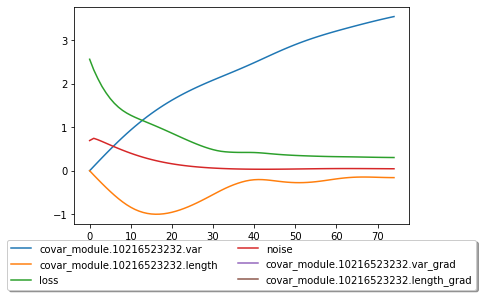

In [11]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [12]:
print(likelihood.noise)
print(likelihood.task_noises)

tensor([0.0449], grad_fn=<AddBackward0>)
tensor([1.0000e-04, 1.0000e-04], grad_fn=<AddBackward0>)


In [13]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

[  2.000000000000000?                    0  0.6065000000000000?  0.6065000000000000?]
[                   0                    1 -0.6065000000000000?  0.6065000000000000?]
[ 0.6065000000000000? -0.6065000000000000?   2.000000000000000?              0.?e-18]
[ 0.6065000000000000?  0.6065000000000000?              0.?e-18   1.000000000000000?]

In [14]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-3.0833], requires_grad=True))
('covar_module.10216523232.var', Parameter containing:
tensor(3.5598, requires_grad=True))
('covar_module.10216523232.length', Parameter containing:
tensor(-0.1577, requires_grad=True))


In [15]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(120)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[ 3.5156e+01,  0.0000e+00,  3.4996e+01,  ..., -5.0785e-03,
          6.0705e-04, -3.3287e-03],
        [ 0.0000e+00,  4.8193e+01,  3.9162e+00,  ..., -2.5983e-02,
          3.3287e-03, -1.7420e-02],
        [ 3.4996e+01,  3.9162e+00,  3.5156e+01,  ..., -7.6743e-03,
          9.4546e-04, -5.0785e-03],
        ...,
        [-5.0785e-03, -2.5983e-02, -7.6743e-03,  ...,  4.8193e+01,
          3.9162e+00,  4.7535e+01],
        [ 6.0705e-04,  3.3287e-03,  9.4546e-04,  ...,  3.9162e+00,
          3.5156e+01,  0.0000e+00],
        [-3.3287e-03, -1.7420e-02, -5.0785e-03,  ...,  4.7535e+01,
          0.0000e+00,  4.8193e+01]])
torch.return_types.eig(
eigenvalues=tensor([[ 1.1547e+03,  0.0000e+00],
        [ 1.1072e+03,  0.0000e+00],
        [ 7.4665e+02,  0.0000e+00],
        [ 5.4860e+02,  0.0000e+00],
        [ 3.4379e+02,  0.0000e+00],
        [ 1.7841e+02,  0.0000e+00],
        [ 6.4662e+01,  0.0000e+00],
        [ 1.8212e+01,  0.0000e+00],
        [ 4.2093e+00,  0.0000e+00],
        

Text(0.5, 1.0, 'Observed Values (Likelihood)')

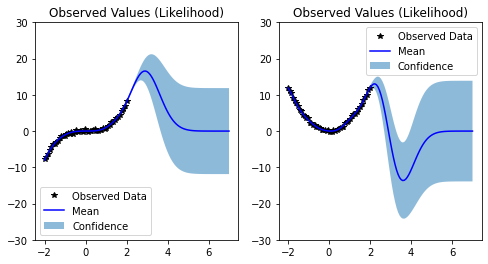

In [16]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [17]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

[ 7 10]

# Test Diffable SE Kernel

In [18]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [19]:
X = torch.linspace(float(-2), float(2), int(1))

In [20]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1).diff(x1).diff(x2)(int(v1), int(v2), lengthscale, variance))
cov_matr

[[3.0]]

In [44]:
print(SE)
print(SE.diff(x2))
#print(SE.diff(x1).diff(x2))
#print(SE.diff(x1).diff(x2).diff(x1))
#print(SE.diff(x1).diff(x2).diff(x1).diff(x2))
#float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)
(x1, x2, l, sigma) |--> sigma^2*(x1 - x2)*e^(-1/2*(x1 - x2)^2/l^2)/l^2


In [40]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1^3 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

tensor([[2.7183]], grad_fn=<AddBackward0>)

In [23]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [24]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

[l_11 l_12 l_13]
[l_21 l_22 l_23]
[l_31 l_32 l_33]
[m_11 m_12 m_13]
[m_21 m_22 m_23]
[m_31 m_32 m_33]
[r_11 r_12 r_13]
[r_21 r_22 r_23]
[r_31 r_32 r_33]
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_11 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_21 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_31
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_12 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_22 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_32
(l_11*m_11 + l_12*m_21 + l_13*m_31)*r_13 + (l_11*m_12 + l_12*m_22 + l_13*m_32)*r_23 + (l_11*m_13 + l_12*m_23 + l_13*m_33)*r_33
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_11 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_21 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_31
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_12 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_22 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_32
(l_21*m_11 + l_22*m_21 + l_23*m_31)*r_13 + (l_21*m_12 + l_22*m_22 + l_23*m_32)*r_23 + (l_21*m_13 + l_22*m_23 + l_23*m_33)*r_33
(l_31*m_11 + l_32*m_21 + l_33*m_31)*r_11 + (l_31*m_12 + l_32*m_22 + l_33*m_32)*r_21 +

In [25]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [26]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


x-pos: 0 y-pos: 0 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---
x-pos: 0 y-pos: 1 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---
x-pos: 1 y-pos: 0 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---
x-pos: 1 y-pos: 1 x1, x2: -2.0, -2.0
(x1-x2)^2: 0.0 exp((x1-x2)^2): 1.0
val: 1.0
---


[[1.0, 1.0], [1.0, 1.0]]

In [27]:
print(X)
print(torch.Tensor(cov_matr).eig())

tensor([-2.])
torch.return_types.eig(
eigenvalues=tensor([[2., 0.],
        [0., 0.]]),
eigenvectors=tensor([]))


In [28]:
exp(-(-2-0.66)^2/(2))

0.0290772266655467

In [29]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

List of all kernels: [Diff_SE_kernel(), Diff_SE_kernel()]
[[AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)], [AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)]]
tensor([[0.7358, 0.3679],
        [0.3679, 0.3679]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[0.9631, 0.0000],
        [0.1405, 0.0000]], grad_fn=<EigBackward>),
eigenvectors=tensor([], grad_fn=<EigBackward>))


tensor([[0.7358, 0.3679],
        [0.3679, 0.3679]], grad_fn=<CatBackward>)

In [30]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

tensor([[ 2.0000,  0.0000, -0.8120,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  2.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.8120,  0.0000,  2.0000, -0.4060,  0.0000,  1.0000],
        [ 1.0000,  0.0000, -0.4060,  1.0000,  0.0000, -0.4060],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.4060,  0.0000,  1.0000, -0.4060,  0.0000,  1.0000]])
tensor([[2., 1.],
        [1., 1.]])


tensor([[ 2.0000,  1.0000,  0.0000,  0.0000, -0.8120, -0.4060],
        [ 1.0000,  1.0000,  0.0000,  0.0000, -0.4060, -0.4060],
        [ 0.0000,  0.0000,  2.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.8120, -0.4060,  0.0000,  0.0000,  2.0000,  1.0000],
        [-0.4060, -0.4060,  0.0000,  0.0000,  1.0000,  1.0000]])

In [31]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [32]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

[[<__main__.testobject object at 0x26261fcd0>, <__main__.testobject object at 0x26261fb20>], [<__main__.testobject object at 0x26261fb20>, <__main__.testobject object at 0x26261fe80>]]
170
170


In [33]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [34]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

[[AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)], [AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
), AdditiveKernel(
  (kernels): ModuleList(
    (0): diffed_SE_kernel()
    (1): diffed_SE_kernel()
  )
)]]
tensor([[0.3679, 0.0000],
        [0.0000, 0.3679]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[0.3679, 0.0000],
        [0.3679, 0.0000]], grad_fn=<EigBackward>),
eigenvectors=tensor([], grad_fn=<EigBackward>))


tensor([[0.3679, 0.0000],
        [0.0000, 0.3679]], grad_fn=<CatBackward>)

In [35]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

[dx1, 2]

In [36]:
prod([1,2,3])

6

In [37]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

row: 0, col: 0
tensor(1.)
row: 0, col: 1
tensor(2.)
row: 0, col: 2
tensor(3.)
row: 1, col: 1
tensor(5.)
row: 1, col: 2
tensor(6.)
row: 2, col: 2
tensor(9.)


In [38]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

[a b]
[c d]
[dx1 dx1]
[  0 dx1]


[a*dx1 + c*dx1 b*dx1 + d*dx1]
[        c*dx1         d*dx1]

In [47]:
a, b, c, d, x, y = var('a, b, c, d, x, y')
poly = a*b*x^3
poly.operands()

[a, b, x^3]